<a href="https://colab.research.google.com/github/luup-netizen/notion-cover/blob/main/lectures/module2/2-2_timeseries_timedomain/2-2f%20%E2%80%93%20Time-Domain%20Features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, we're going to talk about different statistical methods for summarizing time-series data. We will cover a variety of Python libraries: some that we've already discussed (`numpy`, `pandas`) and then [`scipy`](https://scipy.org/) — a scientific computing library with many tools for digital signal processing.


# Important: Run this code cell each time you start a new session!

In [1]:
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install scipy
!pip install os
!pip install mne
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import os
import mne

ERROR: Could not find a version that satisfies the requirement os (from versions: none)
ERROR: No matching distribution found for os
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 74.4 MB/s eta 0:00:00


In [2]:
!wget -Ncnp https://physionet.org/files/chbmit/1.0.0/chb01/chb01_03.edf

--2025-11-19 19:16:18--  https://physionet.org/files/chbmit/1.0.0/chb01/chb01_03.edf
Resolving physionet.org (physionet.org)... 18.18.42.54
Connecting to physionet.org (physionet.org)|18.18.42.54|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 42399744 (40M) [application/octet-stream]
Saving to: ‘chb01_03.edf’

chb01_03.edf        100%[===================>]  40.44M   331KB/s    in 2m 10s  

2025-11-19 19:18:29 (318 KB/s) - ‘chb01_03.edf’ saved [42399744/42399744]



In [3]:
# Keep track of useful information for the dataset
sampling_rate_hz = 256
eeg_col = 'FP1-F7'

# Read in the data and create a time column
edf = mne.io.read_raw_edf('chb01_03.edf')
df = pd.DataFrame(edf.get_data().T, columns=edf.ch_names)
df['Time'] = np.arange(0, df.shape[0])* (1/sampling_rate_hz)

# Rename and keep useful columns
keep_cols = ['Time', eeg_col]
df = df[keep_cols]
df.rename(columns={eeg_col: 'EEG'}, inplace=True)

# Split off useful chunks of the recording according to annotations
df = df[(df['Time']>=10) & (df['Time']<=15)]
df['Time'] = df['Time'] - df['Time'].min()
df.to_csv('eeg.csv',index=False)

Extracting EDF parameters from /content/chb01_03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/tmp/ipython-input-62628020.py:6: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  edf = mne.io.read_raw_edf('chb01_03.edf')


# Descriptive Statistics

For this notebook, we are going to look at a brief segment of EEG data recorded from a pediatric subject:

In [4]:
df = pd.read_csv('eeg.csv')
df.head()

,Time,EEG
0,0.000000,0.000060
1,0.003906,0.000068
2,0.007812,0.000074
3,0.011719,0.000080
4,0.015625,0.000081


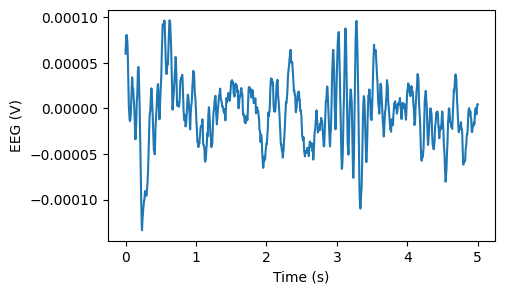

In [5]:
plt.figure(figsize=(5,3))
plt.plot(df['Time'], df['EEG'])
plt.xlabel('Time (s)')
plt.ylabel('EEG (V)')
plt.show() ## a whole bunch of noisy garbage over time
#if you want to summarize, theres a bunch of descriptive statistics we can clculate on the whole data or individual data frames

Here are some common statistical features you might encounter:

| Statistic | &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; Equation &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;| Purpose |
|:--------------:|:-----------:|:-------:|
| Minimum | $\displaystyle x_{min} = \min(x_i)$ | Smallest value of the signal |
| Maximum | $\displaystyle x_{max} = \max(x_i)$ | Largest value of the signal |
| Mean | $\displaystyle \mu = \frac{1}{n}\sum_{i=1}^{n} x_i$ | Average value of the signal |
| Standard deviation | $\displaystyle \sigma = \left[ \frac{1}{n-1}\sum_{i=1}^{n} (x_i-\mu)^2 \right]^{1/2}$  | Signal variation |
| Root mean square | $\displaystyle x_{RMS} = \left[ \frac{1}{n}\sum_{i=1}^{n} x_i^2 \right]^{1/2}$ | Signal variation |
| Skewness | $\displaystyle x_{skew} = \frac{\sum_{i=1}^{n} (x_i-\mu)^3}{(n-1)\sigma^3} $ | Degree of asymmetry |
| Kurtosis | $\displaystyle x_{kurt} = \frac{\sum_{i=1}^{n} (x_i-\mu)^4}{(n-1)\sigma^4}$ | Degree of peakedness |

Another set of descriptive statistics that is worth remembering is a ***percentile***, which is value below which a certain percent of numerical data falls. For example, the 0th-percentile is equivalent to the minimum because no values are lower than it, while the 100th-percentile is equivalent to the maximum because all values are lower than it.

Percentiles can be useful for situations when we want to understand the range of our data without being overly sensitive to extreme outliers. Imagine that we are monitoring a patient's daily step count. If they typically take 5,000 $\pm$ 500 steps a day but go on a hike on the weekend that took 15,000 steps, we may not want to count that hike when we are identifying the most steps that patient typically takes.

Fortunately, many data science libraries — `numpy`, `pandas`, and `scipy` — provide functions and methods for most of the standard statistical measures you will likely need in order to summarize useful information about your time-series data.

In [ ]:
print(f"Standard deviation: {np.std(df['EEG'])} V")
print(f"0th percentile: {np.percentile(df['EEG'], 0)} V")
print(f"50th percentile: {np.percentile(df['EEG'], 50)} V")

Remember the code we wrote to make a peak detector earlier? `scipy` provides a much fancier one with all sorts of parameters we can configure, such as the required height of a valid peak or the minimum spacing between successive peaks.

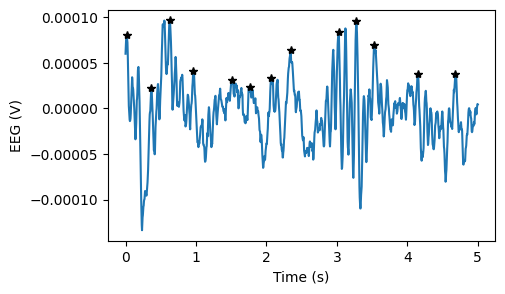

In [6]:
from scipy.signal import find_peaks
min_height = 0.00002 #@param {type:"slider", min:1e-5, max:5e-5, step:1e-5}
min_distance_samples = 50 #@param {type:"slider", min:25, max:100, step:25}

times = df['Time'].values
eeg = df['EEG'].values
peaks, _ = find_peaks(eeg, height=min_height, distance=min_distance_samples)
plt.figure(figsize=(5, 3))
plt.plot(times, eeg)
plt.plot(times[peaks], eeg[peaks], "k*")
plt.xlabel('Time (s)')
plt.ylabel('EEG (V)')
plt.show()

These are just some examples of the thousands of tools libraries provide to help you manipulate time-series data. We will touch on some more specific examples as we begin to work on other kinds of data (e.g., images, audio), but you should now have enough background to understand how to use much of what's available to you!

# Descriptive Statistics Over Time

Let's use everything we've learned to extract meaningful information about our EEG signal. In this example, we want to identify periods of low- and high-activity levels as the signal evolves over time.

For the sake of simplicity, we are going to use a 0.5-second window with 0% overlap in order to split our signal into distinct chunks. For each window, we will compute the standard deviation to determine how much activity is happening in that part of the signal. We will apply a hand-selected threshold to see if that part of the signal has high or low variance, and we will label that chunk accordingly. The pseudocode for this algorithm is as follows:

```
initialize our window
add a DataFrame column to store the activity level
assume that activity level is LOW for all samples

while the window had not reached the end of the signal:
    grab the data within the window
    compute the standard deviation in the window
    if it is above a threshold
        set the activity level for that data to HIGH
    move the window
```

And this is one way we can implement this algorithm:

In [ ]:
def classify_activity(df, width, threshold):
    """
    df: a DataFrame containing EEG values over time
    width: the width of the windows measured in seconds
    threshold: the minimum threshold for high activity level
    """
    # Initialize the start and end of the window
    start_time = 0
    end_time = start_time + width

    # Set the stride to be the same as the width for 0% overlapping windows
    stride = width

    # Initialize the column for storing activity level
    df['IsActivityHigh'] = False

    # Stop generating windows if it would go past the end of the signal
    signal_duration = df['Time'].max()
    while end_time <= signal_duration:
        # Grab the current window by filtering indexes according to time
        row_selector = (df['Time'] >= start_time) & (df['Time'] <= end_time)
        window_times = df['Time'][row_selector]
        window_data = df['EEG'][row_selector]

        # Calculate the activity level
        window_activity_level = window_data.std()

        # Update the activity level if it is high
        if window_activity_level > threshold:
            df.loc[row_selector, 'IsActivityHigh'] = True

        # Move the window over by a stride
        start_time += stride
        end_time = start_time + width

    # Show the activity level using transparency
    plt.figure(figsize=(5,3))
    plt.plot(df['Time'], df['EEG'])
    for idx in range(1, df.shape[0]):
        if df['IsActivityHigh'].iloc[idx]:
            plt.axvspan(df['Time'].iloc[idx-1], df['Time'].iloc[idx],
                        color='r', alpha=0.5, lw=0)
        else:
            plt.axvspan(df['Time'].iloc[idx-1], df['Time'].iloc[idx],
                        color='g', alpha=0.5, lw=0)
    plt.xlabel('Time (s)')
    plt.ylabel('EEG (V)')
    plt.title('Activity Level (green = low, red = high)')
    plt.show()

In [ ]:
window_width = 0.5 #@param {type:"slider", min:0.5, max:1, step:0.25}
activity_threshold = 0.00005 #@param {type:"slider", min:1e-5, max:5e-5, step:1e-5}
classify_activity(df, window_width, activity_threshold)